# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import json

2024-03-26 12:58:52.144264: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
metrics_file = Path("./output/coingame_maa2c_classical_small.json")

metrics_file.parent.expanduser().mkdir(parents=True, exist_ok=True)

In [5]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [6]:
import numpy as np


def generate_model_actor_classical(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    # layers += [keras.layers.Input(shape=(observation_dim,), sparse=True)]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

def generate_model_critic_classical(units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    # layers += [keras.layers.Input(shape=(n_agents, observation_dim,), sparse=True)]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [7]:
# Shared actor.
model_actor = generate_model_actor_classical(
    n_actions=n_actions,
    units=[16, 8],
    name=f"actor-classical-shared"
    )
optimizer_actor = keras.optimizers.Adam(learning_rate=1e-3)

model_actor.build((None, observation_dim))
model_actor.summary()

Model: "actor-classical-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 16)                592       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 policy (Dense)              (None, 4)                 36        
                                                                 
Total params: 764
Trainable params: 764
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Classical critic.
model_critic = generate_model_critic_classical(
    units=[16, 8],
    name=f"critic-classical-joint"
    )
optimizer_critic = keras.optimizers.Adam(learning_rate=1e-3)

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "critic-classical-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 72)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1168      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 v (Dense)                   (None, 1)                 9         
                                                                 
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [10]:
# Train models using algorithm.
reward_history, metrics_history = algo.train(n_episodes=3000)

# Save results to file.
algo.save_train_results(metrics_file, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 3000: 100%|██████████| 3000/3000 [20:37<00:00,  2.42episode/s, coins_collected=30, discounted_reward=20.2, episode_reward=[11. 15.], own_coin_rate=0.933, own_coins_collected=28, undiscounted_reward=26]


In [11]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file)

Text(0.5, 1.0, 'Score')

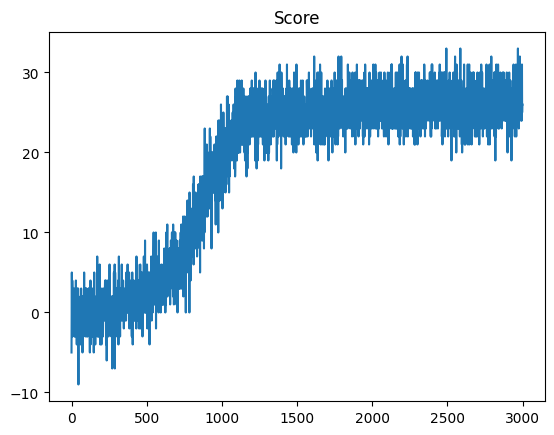

In [12]:
score = np.sum(reward_history, axis=-1)
plt.plot(score)
plt.title('Score')

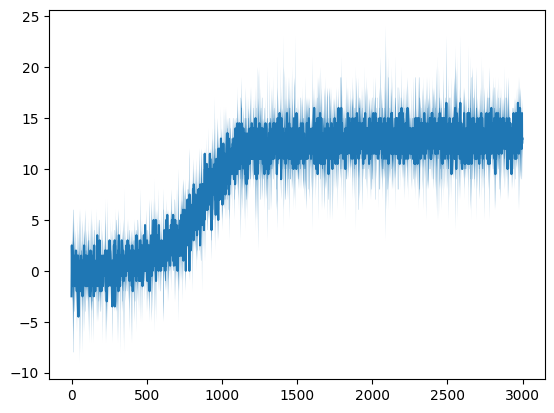

In [13]:
reward_history_mean = np.mean(reward_history, axis=-1)
reward_history_std = np.std(reward_history, axis=-1)
x = np.arange(len(reward_history_mean))
plt.plot(x, reward_history_mean)
plt.fill_between(x, reward_history_mean + reward_history_std, reward_history_mean - reward_history_std)

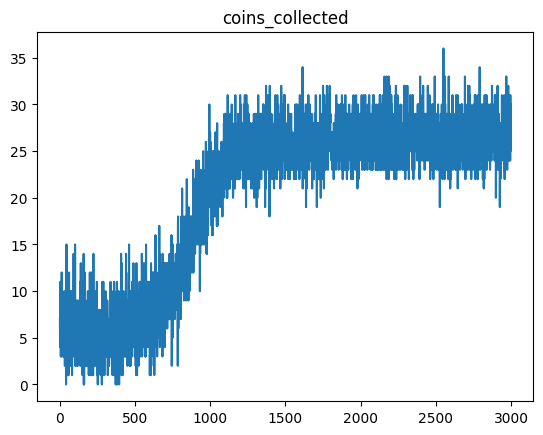

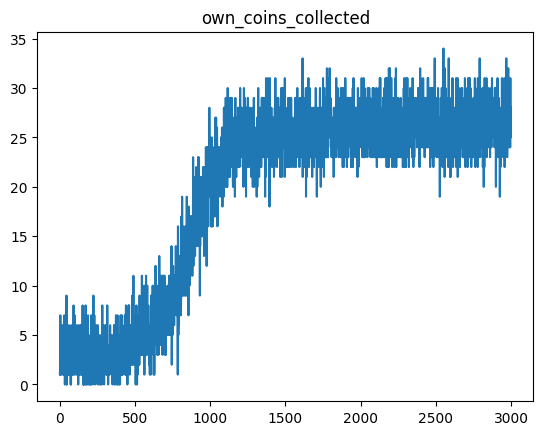

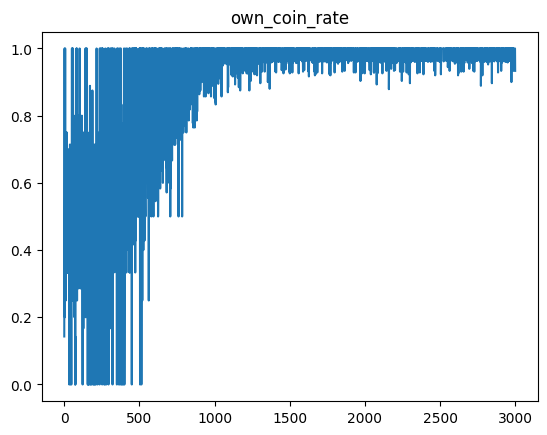

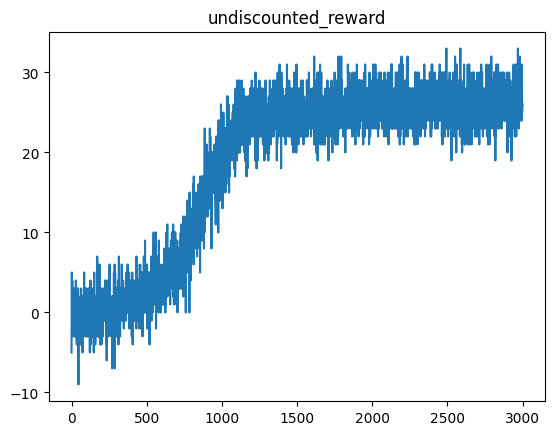

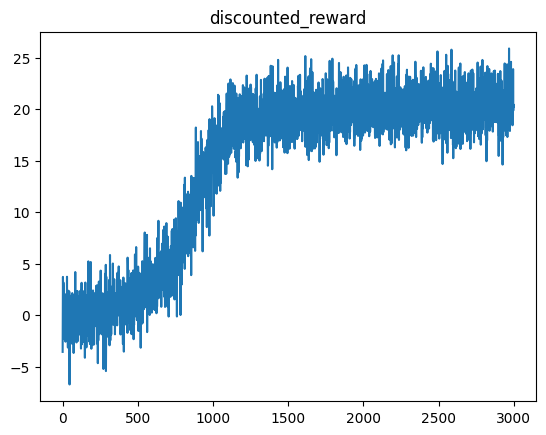

In [14]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v)